# Break Through Tech - Allstate Team 1b
## Author: Minh Le
---

This file is used to build a Generalized Linear Model (GLM) from the dataset given by Allstate.

### 1. Import Libraries and Dataset

In [27]:
# ================================
# 1. IMPORT LIBRARIES
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

Shape: (188318, 132)

Data types:
 object     116
float64     15
int64        1
Name: count, dtype: int64

Missing values: 0


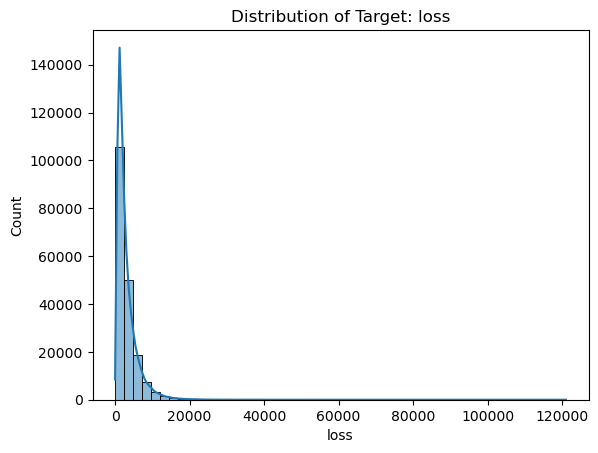

In [28]:
# ================================
# 2. LOAD DATA
# ================================
df = pd.read_csv('../data/claims_data.csv')

print("Shape:", df.shape)
print("\nData types:\n", df.dtypes.value_counts())
print("\nMissing values:", df.isnull().sum().sum())

# Check target
sns.histplot(df["loss"], bins=50, kde=True)
plt.title("Distribution of Target: loss")
plt.show()


In [29]:
len(df)

188318

Since the idea here is to use GLM, we need to know the distribution of the response variable. I will start by plotting out the distribution of the response variable (`loss`). 

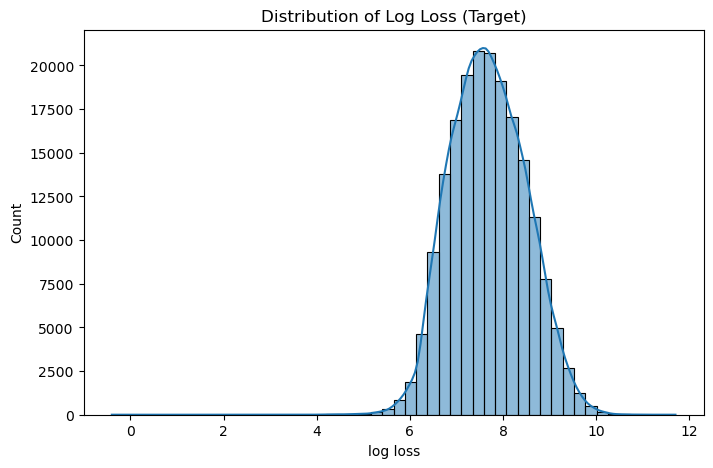

In [30]:
df['log loss'] = np.log(df['loss'])
plt.figure(figsize=(8,5))
sns.histplot(df['log loss'], bins=50, kde=True)
plt.title("Distribution of Log Loss (Target)")
plt.show()

The claim severity is highly skewed (right-skewed). Therefore, I will start by building a model with gamma distribution.

In [ ]:
# ================================
# 3. FEATURE SELECTION
# ================================

# Continuous features
# Based on EDA: cont11-cont12 are duplicates; cont1, cont6, cont9, cont10 highly correlated
# We'll keep one representative per cluster.
continuous_keep = [
    "cont1", "cont6", "cont7", "cont8", "cont10", "cont13", "cont14"
]

# Categorical features
# Strong signals:
high_cats = ["cat46", "cat40", "cat47", "cat45", "cat41", "cat57"]
# Medium signals:
medium_cats = ["cat65", "cat66", "cat59", "cat67", "cat58", "cat61"]

# Add a few early features that showed consistent difference
extra_cats = ["cat3", "cat7", "cat10", "cat11", "cat12", "cat16", "cat17"]

categorical_keep = high_cats + medium_cats + extra_cats

# Combine selected columns

categorical_cols = [c for c in df.columns if c.startswith("cat")]
continuous_cols = [c for c in df.columns if c.startswith("cont")]

# selected_features = continuous_keep + categorical_keep
selected_features = categorical_cols + continuous_cols
print("Total selected features:", len(selected_features))

Total selected features: 130


In [31]:
# ================================
# 4. DATA PREPARATION
# ================================
id_col = "id"
target_col = "loss"

X = df[selected_features]
y = np.log1p(df[target_col])   # log-transform target to stabilize skew

# Identify column types
cat_cols = [c for c in categorical_cols if c in X.columns]
cont_cols = [c for c in continuous_cols if c in X.columns]

print("Categorical features:", len(cat_cols))
print("Continuous features:", len(cont_cols))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Categorical features: 116
Continuous features: 14


In [32]:
# ================================
# 5. PREPROCESSING PIPELINE
# ================================
# Imputation + Scaling for continuous
cont_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# One-Hot Encoding for categorical (these are mostly low/medium-cardinality)
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

# Combine both into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_pipeline, cont_cols),
        ("cat", cat_pipeline, cat_cols)
    ],
    remainder="drop"
)


- Do more preprocessing GLM 
- Play around with interactions
- Transformation (e.g. quadratic)

In [33]:
# ================================
# 6. MODEL TRAINING
# ================================
glm = ElasticNetCV(
    cv=5,
    l1_ratio=np.linspace(0.1, 0.9, 5),
    alphas=np.logspace(-4, 1, 30),
    random_state=42,
    n_jobs=-1,
    max_iter=15000,
    selection="random"
)


pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", glm)
])

# Fit the model
pipe.fit(X_train, y_train)

print("Best alpha:", pipe.named_steps["model"].alpha_)
print("Best l1_ratio:", pipe.named_steps["model"].l1_ratio_)


Best alpha: 0.0001
Best l1_ratio: 0.1


In [34]:
pipe

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cont', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
# ================================
# 7. MODEL EVALUATION
# ================================
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

def report(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} set:")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAE : {mae:.3f}")
    print(f"  R²  : {r2:.3f}\n")

report(y_train, y_pred_train, "Train")
report(y_test, y_pred_test, "Test")

# Back-transform predictions (exp - 1)
y_pred_real = np.expm1(y_pred_test)
y_test_real = np.expm1(y_test)

report(y_test_real, y_pred_real, "Test (original scale)")

Train set:
  RMSE: 0.562
  MAE : 0.439
  R²  : 0.521

Test set:
  RMSE: 0.560
  MAE : 0.439
  R²  : 0.519

Test (original scale) set:
  RMSE: 2191.099
  MAE : 1243.096
  R²  : 0.412



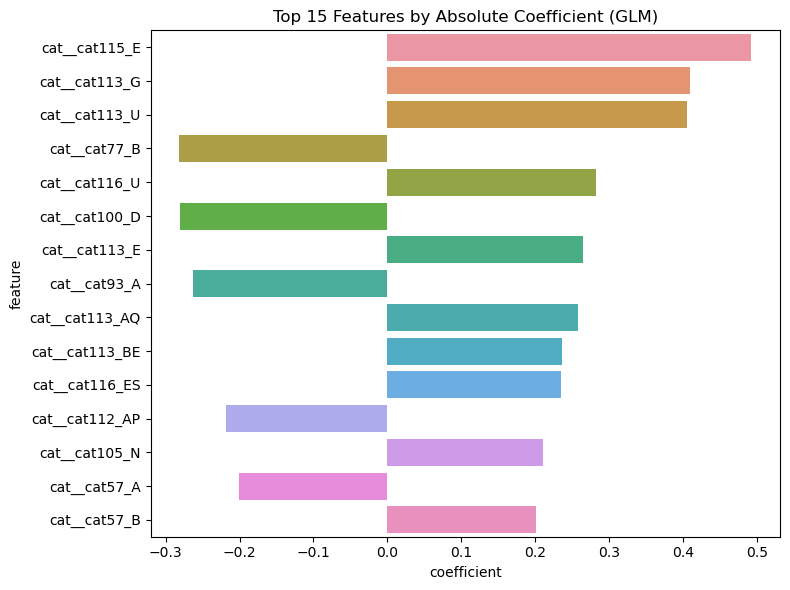

,feature,coefficient
797,cat__cat115_E,0.492003
759,cat__cat113_G,0.408468
772,cat__cat113_U,0.405586
171,cat__cat77_B,-0.281632
1126,cat__cat116_U,0.281309
304,cat__cat100_D,-0.280553
757,cat__cat113_E,0.264793
248,cat__cat93_A,-0.263349
731,cat__cat113_AQ,0.258122
745,cat__cat113_BE,0.236487


In [36]:
# ================================
# 8. FEATURE IMPORTANCE
# ================================
feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()
coefs = pipe.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values("coefficient", key=abs, ascending=False)

# Display top 15 features
plt.figure(figsize=(8,6))
sns.barplot(x="coefficient", y="feature", data=coef_df.head(15))
plt.title("Top 15 Features by Absolute Coefficient (GLM)")
plt.tight_layout()
plt.show()

coef_df.head(20)
